In [1]:
import os
import sys
import math
import json
import torch
import PIL
import numpy as np
from tqdm import tqdm

import scipy.io
from scipy import ndimage
import matplotlib
# from skimage import io
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':8,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.DiffNetFEM import DiffNet2DFEM
from torch.utils import data
from DiffNet.networks.autoencoders import AE
# from e1_stokes_base_resmin import Stokes2D

from pytorch_lightning.callbacks.base import Callback

torch.set_printoptions(precision=10)

from e2_ns_fpc_embedded_airfoil import NS_FPC_Dataset, NS_FPC, OptimSwitchLBFGS

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42


In [6]:
image_dataset_dir = '../test-dataset-fpc'
dirname = './ns_fpc_af/version_4/selected_query_inputs'
case_dir = './ns_fpc_af/version_4'
query_out_path = os.path.join(case_dir, 'selected_query_outputs')
if not os.path.exists(query_out_path):
    os.makedirs(query_out_path)
mapping_type = 'network'
lx = 5.
ly = 12.
Nx = 256
Ny = 128
domain_size = 128
Re = 1.
dir_string = "ns_fpc_af"
max_epochs = 50001
plot_frequency = 1
LR = 2e-4
opt_switch_epochs = max_epochs
load_from_prev = False
load_version_id = 37

enable_progress_bar = True
# print("argv = ", sys.argv)
# if len(sys.argv) > 1:
#     enable_progress_bar = bool(int(sys.argv[1]))
#     print("enable_progress_bar = ", enable_progress_bar)

x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
xx , yy = np.meshgrid(x, y)

net_u = torch.load(os.path.join(case_dir, 'net_u.pt'))
net_v = torch.load(os.path.join(case_dir, 'net_v.pt'))
net_p = torch.load(os.path.join(case_dir, 'net_p.pt'))
net_u.to('cpu')
net_v.to('cpu')
net_p.to('cpu')
dataset = NS_FPC_Dataset(dirname=image_dataset_dir, domain_lengths=(lx,ly), domain_sizes=(Nx,Ny), Re=Re)
network = (net_u, net_v, net_p)
basecase = NS_FPC(network, dataset, domain_lengths=(lx,ly), domain_sizes=(Nx,Ny), batch_size=32, fem_basis_deg=1, learning_rate=LR, plot_frequency=plot_frequency, mapping_type=mapping_type)
#network = GoodNetwork(in_channels=2, out_channels=1, in_dim=64, out_dim=64)
# basecase = Poisson(network, dataset, batch_size=16, domain_size=256)

nsample = len(basecase.dataset)
print("nsample = ", nsample)

100%|██████████| 8/8 [00:00<00:00, 1344.60it/s]

Initializing parametric dataset
dataset size =  (8, 6, 128, 256)
nsample =  8


In [7]:
# def do_query(net_u, net_v, net_p, inputs_tensor, forcing_tensor):
#     domain = inputs_tensor[:,5:6,:,:].type_as(next(self.net_u.parameters()))
#     u = net_u(domain)
#     v = net_v(domain)
#     p = net_p(domain)
    
#     # extract diffusivity and boundary conditions here
#     x = inputs_tensor[:,0:1,:,:]
#     y = inputs_tensor[:,1:2,:,:]
#     bc1 = inputs_tensor[:,2:3,:,:]
#     bc2 = inputs_tensor[:,3:4,:,:]
#     bc3 = inputs_tensor[:,4:5,:,:]
#     domain = inputs_tensor[:,5:6,:,:]

#     # apply boundary conditions
#     u_bc = self.u_bc.unsqueeze(0).unsqueeze(0).type_as(u)
#     v_bc = self.v_bc.unsqueeze(0).unsqueeze(0).type_as(u)
#     p_bc = self.p_bc.unsqueeze(0).unsqueeze(0).type_as(u)

#     u = torch.where(bc1>=0.5, u_bc, u)
#     u = torch.where(domain<0.5, domain, u)
#     v = torch.where(bc2>=0.5, v_bc, v)
#     v = torch.where(domain<0.5, domain, v)
#     # p = torch.where(bc3>=0.5, p_bc, p)

#     return u, v, p

In [8]:
net_u.parameters().__next__().device

device(type='cpu')

In [9]:
with torch.no_grad():
    for i in range(nsample//10+1):
        id0 = 10*i
        id1 = id0+10
        if id1 > nsample:
            id1 = nsample

        # core query code
        inputs, forcing = basecase.dataset[id0:id1]
        u, v, p, u_x_gp, v_y_gp = basecase.do_query(inputs, forcing)
#         query_plot_contours_and_save(query_out_path, nu_par_list, f_par_list, u_par_list, i)

In [10]:
u = u.squeeze().cpu()
v = v.squeeze().cpu()
p = p.squeeze().cpu()

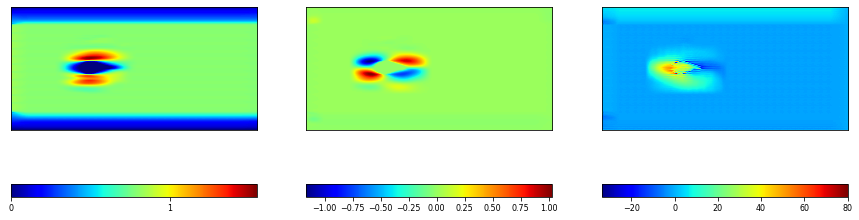

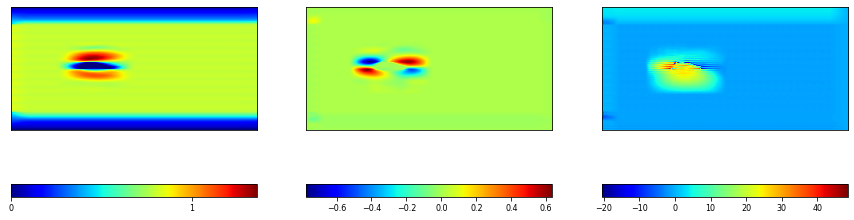

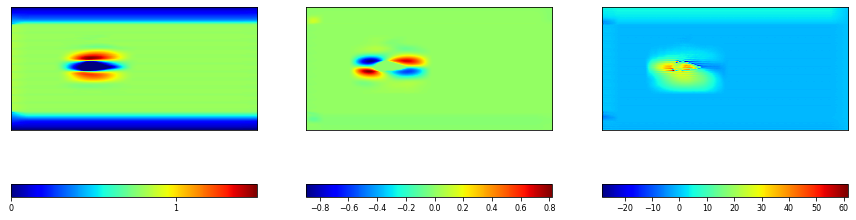

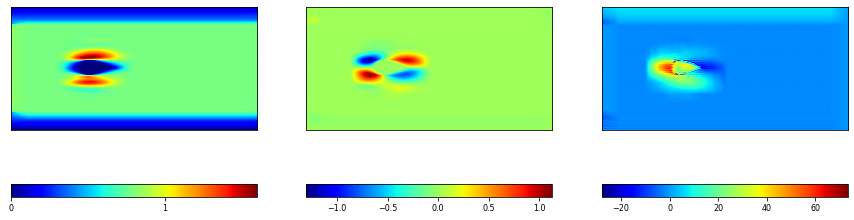

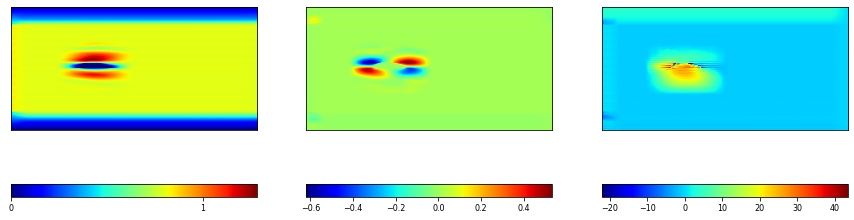

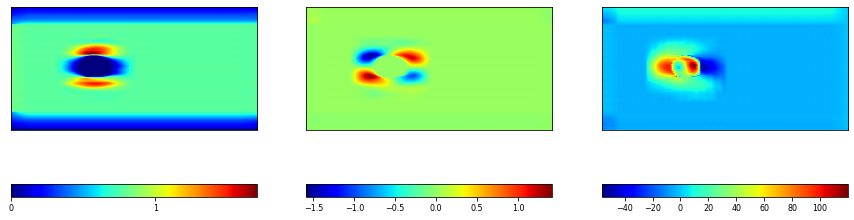

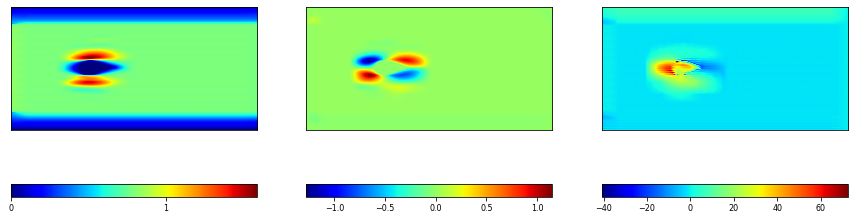

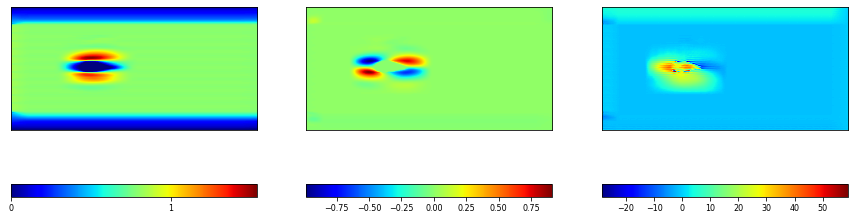

In [12]:
for i in range(nsample):
    # core query code
    ui = u[i]
    vi = v[i]
    pi = p[i]
    
    # plotting
    num_query = 1
    plt_num_row = num_query
    plt_num_col = 3
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(5*plt_num_col,10*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
#     fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2*plt_num_col,2*plt_num_row),
#                         subplot_kw={'aspect': 'auto'},sharey=True)
    #fig.tight_layout()
    for ax in axs:        
        ax.set_xticks([])
        ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        im0 = axs[0].imshow(ui,cmap='jet')
        cb = fig.colorbar(im0, ax=axs[0], fraction=0.04, pad=0.1,orientation="horizontal")
        cb.set_ticks([0,1])
        cb.set_ticklabels([0,1])
        im1 = axs[1].imshow(vi,cmap='jet')
        fig.colorbar(im1, ax=axs[1], fraction=0.04, pad=0.1,orientation="horizontal") 
        im2 = axs[2].imshow(pi,cmap='jet')
        fig.colorbar(im2, ax=axs[2], fraction=0.04, pad=0.1,orientation="horizontal") 
    # plt.close('all')
#     plt.tight_layout()
    plt.savefig(os.path.join(query_out_path,'q_'+str(i)+'.png'))
    plt.show()   

In [15]:
nsample

8

In [19]:
iii, fff = basecase.dataset[0:2]

In [20]:
iii.shape

torch.Size([2, 6, 128, 256])

In [21]:
fff.shape

torch.Size([1, 6, 128, 256])

In [25]:
from DiffNet.networks.resnets import ResNet
from DiffNet.networks.unets import UNetRes

In [23]:
rn = ResNet(in_channels=1, out_channels=1, num_hidden_features=2, n_resblocks=5)

TypeError: object of type 'int' has no len()

In [26]:
gn = GoodNetwork(in_channels=1, out_channels=1, in_dim=64, out_dim=64)

TypeError: 'int' object is not iterable